In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import scipy.stats

# Introduction

During the first lecture we have seen that the goal of machine learning is to train (learn/fit) a 
**model** on a **dataset** such that we will be able to answer several questions about the data using
the model. Some useful questions are:
1. Predict a target $y$ for a new input $x$: predict what is in an image, recognize some audio sample, tell if the stock price will go up or down...
2. Generate new sample $x$ similar to those form the training dataset. Alternatively, given part of a generate the other part (e.g. given half of an image generate the other half).

Historically, similar questions were considered by statisticians. In fact, machine learning is very similar to statistics. Some people claim that there is very little difference between the two, and a tongue-in-cheek definition of machine learning is "statistics without checking for assumptions", to which ML practitioners reply that they are at least able to solve problems that are too complex for a through and formal statistical analysis. 

Due to the similarity of the two fields we will today explore a few examples of statistical inference. Some of the resulting concepts (maximum likelihood, interpreting the outputs of a model as probabilities) will be used through the semester.

# Statistical Inference

Consider the polling problem:
1. There exists **a population** of individuals (e.g. voters).
2. The individuals have a voting preference (party A or B).
3. We want the fraction $\phi$ of voters that prefer A.
4. But we don't want to ask everyone (run an election)!

Instead we want to conduct a poll (choose a **sample** of people 
and get their mean preference $\bar\phi$).

Questions:
1. How are $\phi$ and $\bar\phi$ related?
2. What is our error?
3. How many persons do we need to ask to achieve a desired error?

# Polling

Suppose there is a large population of individuals, that support either candidate A or candidate B. We want to establish the fraction of supporters of A in the population $\phi$.

We will conduct an opinion poll asking about the support for each party. We will choose randomly a certain number of people, $n$, and ask them about their candidates.

We want to use the results of the poll to establish:
1.  an estimate of the true population parameter $\phi$
2.  our confidence about the interval

First, we define a formal model of sampling. We will assume that the population is much bigger than the small sample. Thus we will assume a *sampling with replacement* model: each person is selected independently at random from the full population. We call such a sample IID (Independent Identically Distributed).

Having the sampling model we establish that the number of supporters of A in the sample follows a *binomial distribution*. 

For the binomial distribution with $n$ trials and probability of success $\phi$ the expected number of successes is $n\phi$ and the variance is $n\phi(1-\phi)$. 

Alternatively, the *fraction* of successes in the sample has the expected value $\phi$ and variance $\frac{\phi(1-\phi)}{n}$. 

Lets plot the PMF (Probability Mass Function) of the number of successes.

In [4]:
# Poll variability check: draw samples form the binomial distribution

n = 50
phi = 0.6

sample = random.rand(n)<phi

print ("Made %d trials. Fraction of A supporters: %.2f (true fraction: %.2f)" % 
       (n, 1.0*sample.sum()/n, phi))

Made 50 trials. Fraction of A supporters: 0.64 (true fraction: 0.60)


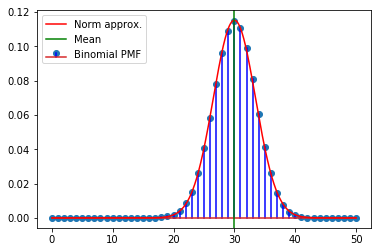

In [5]:
# model parameters
n = 50
phi = 0.6

# the binomial distribution
model = scipy.stats.binom(n=n, p=phi)
x = arange(n+1)

# plot the PMF - probability mass function
stem(x, model.pmf(x), 'b', label='Binomial PMF')

# plot the normal approximation
mu = phi * n
stdev = sqrt(phi*(1-phi) * n)
model_norm = scipy.stats.norm(mu, stdev)
x_cont = linspace(x[0], x[-1], 1000)
plot(x_cont, model_norm.pdf(x_cont), 'r', label='Norm approx.')

axvline(mu, *xlim(), color='g', label='Mean')

legend(loc='upper left')

In Statistics and Machine Learning we only have access to the sample. The goal is to learn something useful about the unknown population. Here we are interested in the true heads probability $\phi$.

The MLE (Maximum Likelihood Estimator) for $\phi$ is just the sample mean $\bar\phi$. However, how precise it is? We want the (sample dependent) confidence interval around the sample mean, such that in 95% of experiments (samples taken), the true unknown population parameter $\phi$ is in the confidence interval.

Formally we want to find $\bar\phi$ and $\epsilon$ such that $P(\bar\phi-\epsilon \leq \phi \leq \bar\phi + \epsilon) > 0.95$ or, equivalently, such that $P(|\phi-\bar\phi| \leq \epsilon) > 0.95$.

Note: from the sampling model we know that for a large enough sample (>15 persons) the random variable denoting the sample mean $\bar\phi$ is approximately normally distributed with mean $\phi$ and standard deviation $\sigma = \sqrt{(\phi(1-\phi)/n)}$. However we do not know $\phi$. When designing the experiment, we can take the worse value, which is 0.5. Alternatively, we can plug for $\phi$ the estimated sample mean $\bar\phi$. Note: we are being too optimistic here, but the error will be small.

For a standard normal random variable (mean 0 and standard deviation 1) 96% of samples fall within the range $\pm 1.96$. 

Therefore the confidence interval is approximately $\bar\phi \pm 1.96\sqrt{\frac{\bar\phi(1-\bar\phi)}{n}}$.


Average confidence interval is phi_bar +-0.030350
Out of 10000 experiments, the true phi fell into the confidence interval 9434 times.


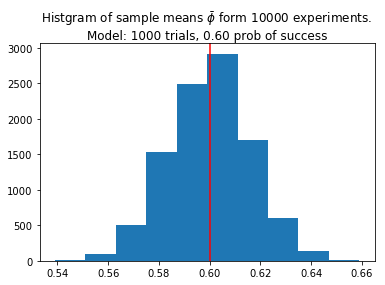

In [79]:
phi=0.6
n=1000
n_experiments=10000

samples = rand(n_experiments, n)<phi
phi_bar = samples.mean(1)

hist(phi_bar)
axvline([phi], color='r')
title('Histgram of sample means $\\bar\\phi$ form %d experiments.\n'
      'Model: %d trials, %.2f prob of success'%(n_experiments,n,phi))

confidence_intervals = zeros((n_experiments, 2))
confidence_intervals[:,0] = phi_bar - 1.96*np.sqrt(phi_bar*(1-phi_bar)/n)
confidence_intervals[:,1] = phi_bar + 1.96*np.sqrt(phi_bar*(1-phi_bar)/n)

#note: this also works, can you exmplain how the formula works in numpy?
confidence_intervals2 = phi_bar[:,None] + [-1.96, 1.96] * np.sqrt(phi_bar*(1-phi_bar)/n).reshape(-1,1)
assert np.abs(confidence_intervals-confidence_intervals2).max()==0

good_experiments = (confidence_intervals[:,0]<phi) & (confidence_intervals[:,1]>phi)

print ("Average confidence interval is phi_bar +-%f" 
       % ((confidence_intervals[:,1]-confidence_intervals[:,0]).mean()/2.0,))

print ("Out of %d experiments, the true phi fell into the confidence interval %d times."
       % (n_experiments, good_experiments.sum()))

Practical outcome: in the worst case ($\phi=0.5$) the 95% confidence interval is $\pm 1.96\sqrt{\frac{0.5(1-0.5)}{n}} = \pm \frac{0.975}{\sqrt{n}}$. To get the usually acceptable polling error of 3 percentage points, one needs to sample 1056 persons. Polling companies typically ask between 1000-3000 persons.

Questions:
1. How critical is the IID sampling assumption?
2. What do you think is a larger problem: approximating the PDF with a Gaussian distribution, or people lying in the questionnaire?

# Bayesian reasoning

We will treat $\phi$ - the unknown fraction of A supporters in the population as a random variable. Its probability distribution will express *our subjective* uncertainty about its value.

We will need to start with a *prior* assumption about our belief of $\phi$. For convenience we will choose a *conjugate prior*, the Beta distribution, because the formula for its PDF is similar to the formula for the likelihood.

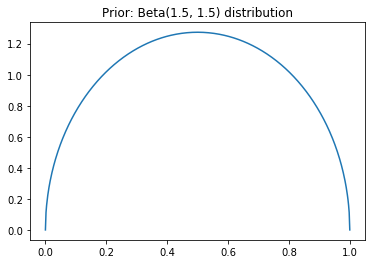

In [6]:
support = linspace(0,1,512)

A=1.5
B=1.5

plot(support, scipy.stats.beta.pdf(support, A,B))
title("Prior: Beta(%.1f, %.1f) distribution" %(A,B))

Then we will collect samples, and after each sample update our belief about $p$.

In [87]:
n_successes = 1
n_failures = 1
phi = 0.6

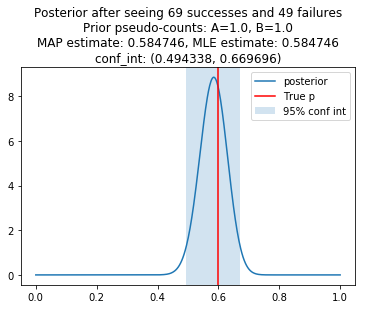

In [104]:
for _ in xrange(100):
    if rand() < phi:
        n_successes += 1
    else:
        n_failures +=1

plot(support, scipy.stats.beta.pdf(support, A+n_successes, B+n_failures), label='posterior')
axvline(phi, color='r', label='True p')
conf_int_low, conf_int_high = scipy.stats.beta.ppf((0.025,0.975), A+n_successes, B+n_failures)
axvspan(conf_int_low, conf_int_high, alpha=0.2, label='95% conf int')
title("Posterior after seeing %d successes and %d failures\n"
      "Prior pseudo-counts: A=%.1f, B=%.1f\n"
      "MAP estimate: %f, MLE estimate: %f\n"
      "conf_int: (%f, %f)"% (n_successes, n_failures, A, B, 
                             1.0*(A+n_successes-1)/(A+n_successes+B+n_failures-2),
                             1.0*n_successes/(n_successes+n_failures),
                             conf_int_low, conf_int_high))
legend()

Please note: in the Bayesian framework we treat the quantities we want to estimate as random variables. 

We need to define our prior beliefs about them. In the example, the prior was a Beta distribution.

After seeing the data we update our belief about the world. In the example, this is vary easy - we keep running counts of the number of failures and successes observed. We update them seeing the data. The prior conveniently can be treated as *pseudo-counts*. 

To summarize the distribution over the parameter, we typically take its mode (the most likely value), calling the approach MAP (Maximum a Posteriori).